In [1142]:
!pip install hnswlib polars  --quiet
!pip install shap gradio --quiet

In [1143]:
# Suppress warnings
import re
import warnings

import gradio as gr
import hnswlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import xgboost as xgb
from scipy.spatial import distance
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

In [1144]:
# Use alternative encoding to avoid UnicodeDecodeError
df = pl.read_csv('../data/fy2022_archived_opportunities.csv', encoding='latin-1')

# Get the first 85000 rows
df = df.tail(85000)
df

NoticeId,Title,Sol#,Department/Ind.Agency,CGAC,Sub-Tier,FPDS Code,Office,AAC Code,PostedDate,Type,BaseType,ArchiveType,ArchiveDate,SetASideCode,SetASide,ResponseDeadLine,NaicsCode,ClassificationCode,PopStreetAddress,PopCity,PopState,PopZip,PopCountry,Active,AwardNumber,AwardDate,Award$,Awardee,PrimaryContactTitle,PrimaryContactFullname,PrimaryContactEmail,PrimaryContactPhone,PrimaryContactFax,SecondaryContactTitle,SecondaryContactFullname,SecondaryContactEmail,SecondaryContactPhone,SecondaryContactFax,OrganizationType,State,City,ZipCode,CountryCode,AdditionalInfoLink,Link,Description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""ec7b6888f4a74dc5bdcb67a64e7e0d…","""16--SENSOR,POSITION BLO""","""N0038322RP161""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:39.726-05""","""Solicitation""","""Solicitation""","""auto15""","""2022-03-22""","""""","""""","""2022-03-07T00:00:00-05:00""","""333999""","""1680""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""Telephone: 2156975809""","""WILLIAM.J.RYAN1@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/ec7b6888f4…","""CONTACT INFORMATION|4|TBD|TBD|…"
"""53ea116fb7c3448ea187f27ab33ba3…","""15--FAIRING,AIRCRAFT""","""N0038322RD075""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:33.016-05""","""Solicitation""","""Solicitation""","""auto15""","""2022-03-10""","""""","""""","""2022-02-23T00:00:00-05:00""","""333999""","""1560""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""Telephone: 2156972217""","""MARY.R.COLE@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/53ea116fb7…","""ITEM UNIQUE IDENTIFICATION AND…"
"""a429f48cb91442b5b7f1fd87a2a59f…","""15--FAIRING,AIRCRAFT""","""N0038322RD075""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:31.575-05""","""Solicitation""","""Solicitation""","""auto15""","""2022-03-10""","""""","""""","""2022-02-23T00:00:00-05:00""","""333999""","""1560""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""Telephone: 2156972217""","""MARY.R.COLE@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/a429f48cb9…","""ITEM UNIQUE IDENTIFICATION AND…"
"""a9207c99f6bd470385437a4c519d13…","""15--FAIRING,AIRCRAFT""","""N0038322RD075""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:30.33-05""","""Presolicitation""","""Presolicitation""","""auto15""","""2022-01-26""","""""","""""","""2022-02-23T00:00:00-05:00""","""""","""1560""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""MARY R. COLE, N721.25, PHONE (…","""MARY.R.COLE@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/a9207c99f6…","""NSN 7R-1560-014884680-KB, TDP …"
"""2d249787f77241f28c9a947533b9ef…","""VXI OCTAL TACHOMETE""","""N0038322QP241""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:23.19-05""","""Solicitation""","""Solicitation""","""auto15""","""2022-03-22""","""""","""""","""2022-03-07T00:00:00-05:00""","""333999""","""99""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""",""

In [1145]:
# Function to clean column names
def clean_names(df):
    """
    Cleans column names of a Polars DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Polars DataFrame

    Returns:
        Polars DataFrame with cleaned column names.
    """
    df.columns = [re.sub(r'\W+', '_', col).lower() for col in df.columns]
    return df

# Load your DataFrame
# df2023 = pl.read_csv('your_dataset.csv')  # Replace with your actual data loading method

# Clean column names
df2022 = clean_names(df)
df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""ec7b6888f4a74dc5bdcb67a64e7e0d…","""16--SENSOR,POSITION BLO""","""N0038322RP161""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:39.726-05""","""Solicitation""","""Solicitation""","""auto15""","""2022-03-22""","""""","""""","""2022-03-07T00:00:00-05:00""","""333999""","""1680""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""Telephone: 2156975809""","""WILLIAM.J.RYAN1@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/ec7b6888f4…","""CONTACT INFORMATION|4|TBD|TBD|…"
"""53ea116fb7c3448ea187f27ab33ba3…","""15--FAIRING,AIRCRAFT""","""N0038322RD075""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:33.016-05""","""Solicitation""","""Solicitation""","""auto15""","""2022-03-10""","""""","""""","""2022-02-23T00:00:00-05:00""","""333999""","""1560""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""Telephone: 2156972217""","""MARY.R.COLE@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/53ea116fb7…","""ITEM UNIQUE IDENTIFICATION AND…"
"""a429f48cb91442b5b7f1fd87a2a59f…","""15--FAIRING,AIRCRAFT""","""N0038322RD075""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:31.575-05""","""Solicitation""","""Solicitation""","""auto15""","""2022-03-10""","""""","""""","""2022-02-23T00:00:00-05:00""","""333999""","""1560""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""Telephone: 2156972217""","""MARY.R.COLE@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/a429f48cb9…","""ITEM UNIQUE IDENTIFICATION AND…"
"""a9207c99f6bd470385437a4c519d13…","""15--FAIRING,AIRCRAFT""","""N0038322RD075""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:30.33-05""","""Presolicitation""","""Presolicitation""","""auto15""","""2022-01-26""","""""","""""","""2022-02-23T00:00:00-05:00""","""""","""1560""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""","""MARY R. COLE, N721.25, PHONE (…","""MARY.R.COLE@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""","""PA""","""PHILADELPHIA""","""19111-5098""","""USA""","""""","""https://sam.gov/opp/a9207c99f6…","""NSN 7R-1560-014884680-KB, TDP …"
"""2d249787f77241f28c9a947533b9ef…","""VXI OCTAL TACHOMETE""","""N0038322QP241""","""DEPT OF DEFENSE""",17,"""DEPT OF THE NAVY""","""1700""","""NAVSUP WEAPON SYSTEMS SUPPORT""","""N00383""","""2022-02-03 06:22:23.19-05""","""Solicitation""","""Solicitation""","""auto15""","""2022-03-22""","""""","""""","""2022-03-07T00:00:00-05:00""","""333999""","""99""","""""","""""","""""","""""","""""","""No""","""""","""""","""""","""""","""""",""

In [1146]:
# Calculate the number of unique values and missing values for each column
summary = pl.DataFrame({
    'column': df2022.columns,
    'unique_values': [df2022[col].n_unique() for col in df2022.columns],
    'missing_values': [df2022[col].null_count() for col in df2022.columns]
})

# Display the summary
print(summary)

shape: (47, 3)
┌───────────────────────┬───────────────┬────────────────┐
│ column                ┆ unique_values ┆ missing_values │
│ ---                   ┆ ---           ┆ ---            │
│ str                   ┆ i64           ┆ i64            │
╞═══════════════════════╪═══════════════╪════════════════╡
│ noticeid              ┆ 85000         ┆ 0              │
│ title                 ┆ 39920         ┆ 0              │
│ sol_                  ┆ 55461         ┆ 0              │
│ department_ind_agency ┆ 67            ┆ 0              │
│ cgac                  ┆ 65            ┆ 4              │
│ …                     ┆ …             ┆ …              │
│ zipcode               ┆ 1078          ┆ 0              │
│ countrycode           ┆ 55            ┆ 0              │
│ additionalinfolink    ┆ 1             ┆ 0              │
│ link                  ┆ 85000         ┆ 0              │
│ description           ┆ 60190         ┆ 0              │
└───────────────────────┴───────────────┴

In [1147]:
# List of categorical columns
categorical_cols = ['title', 'sol_', 'department_ind_agency', 'sub_tier', 'fpds_code', 'office',
                     'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 
                     'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 
                     'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'awardnumber',
                     'awarddate', 'awardee', 'state', 'city', 'zipcode', 'countrycode', 'description']

# Convert all categorical columns to strings
df2022 = df2022.with_columns([pl.col(col).cast(pl.Utf8) for col in categorical_cols])

In [ ]:
# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df2022 = df2022.with_columns([pl.Series(col, le.fit_transform(df2022[col].to_list()))])
    label_encoders[col] = le

# Ensure numerical columns are in the correct format

df2022

In [ ]:
# Separate numeric and non-numeric columns
numeric_cols = df2022.select(pl.col(pl.Float64) | pl.col(pl.Int64)).columns
non_numeric_cols = df2022.select(pl.col(pl.Utf8)).columns
non_numeric_cols

['noticeid',
 'active',
 'award_',
 'primarycontacttitle',
 'primarycontactfullname',
 'primarycontactemail',
 'primarycontactphone',
 'primarycontactfax',
 'secondarycontacttitle',
 'secondarycontactfullname',
 'secondarycontactemail',
 'secondarycontactphone',
 'secondarycontactfax',
 'organizationtype',
 'additionalinfolink',
 'link']

In [ ]:
# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
imputer

SimpleImputer()

In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df2022_df):
    # Filter rows based on column: 'award_'
    df2022_df = df2022_df[(df2022_df['award_'].notna()) & (df2022_df['award_'] != "")]
    return df2022_df

# Loaded variable 'df2022' from kernel state
df2022_df = df2022.to_pandas()

df2022_df_clean = clean_data(df2022_df.copy())
df2022_df_clean.head()

,noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
168,155abf1495584299b2ce826653a146c6,16524,12305,2,72.0,4,109,1447,838,84444,...,,,OFFICE,0,157,0,45,,https://sam.gov/opp/155abf1495584299b2ce826653...,50454
176,29525532896f44fe8a58cc1a0c4b0a7a,7916,47565,13,97.0,35,158,356,1515,84437,...,,,OFFICE,41,140,549,49,,https://sam.gov/opp/29525532896f44fe8a58cc1a0c...,0
213,f4298d2e2e6046e9a7a7bd757fa1929d,10999,49000,13,97.0,35,158,365,1524,84400,...,,,OFFICE,44,491,148,49,,https://sam.gov/opp/f4298d2e2e6046e9a7a7bd757f...,0
230,c7db0b6afb974e1faffeff007099f8c5,14871,868,3,12.0,72,14,929,91,84383,...,,,OFFICE,31,310,526,49,,https://sam.gov/opp/c7db0b6afb974e1faffeff0070...,2294
243,03207f5ec65447ca9b3bd81efe0e1007,7842,32104,13,97.0,35,158,338,1483,84370,...,,,OFFICE,53,527,328,49,,https://sam.gov/opp/03207f5ec65447ca9b3bd81efe...,0


In [ ]:
df2022_df_clean.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award_', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [ ]:
# Define features and target
X = df2022_df_clean.drop('award_', axis=1)
y = df2022_df_clean['award_']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train)

                               noticeid  title   sol_  department_ind_agency  \
35708  70e1043452984f4898c32549f10f6b8c    116    666                      3   
3025   37d8e74fdd1f4f1d83d1c6f802b48c61   4781  44551                     13   
41739  dff71da132474ccb826e09c7505d8658  11601   3511                     34   
45348  10e4a69fc49a432ebd4c2eb8725bdaea  25332   7689                     66   
10303  7df78841050c4f598a2c71c179932d5d   8191  48232                     13   
...                                 ...    ...    ...                    ...   
60902  4e7df2abca6e47c89b157b2953e92e83  37333  53370                     13   
64507  850c0ccaad1348c9abd762949d6893f5   8160  48196                     13   
28418  0f087f6ed74c4b07adb97ffd7c277fe8   9253   3932                     66   
4276   60479b32db134917be76f72448a38a2d   7249  42469                     13   
81805  f0c7e00a5d8e44a0b20bae1661906385   7161  28809                     13   

       cgac  sub_tier  fpds_code  offic

In [ ]:
print(X_test)

                               noticeid  title   sol_  department_ind_agency  \
76630  47bb415eed3442f286c4c21c724f1a8f   6282  37021                     13   
18944  fe084b89bb164fa6ae6eb79bc15601f1   4994  48521                     13   
58139  3c7ea5411b4f4d9f94bd619be1a3d168  30261  11396                     28   
44348  159cd375573c4039998292104cb76942   7216  45139                     13   
72212  0fad9d313db846168b26c351fc85246b   5600  46668                     13   
...                                 ...    ...    ...                    ...   
59785  8dbc902a816340ccb84d6189197a061e   2734  38337                     13   
68549  26a28fc58523423ead3c6ade87c9308d  28748  11382                     28   
46786  7aebfe61c14d462da9701742ecc3a28a   1008  34251                     13   
37248  cc89c3d663f3462996036ea22cb3909b  11438   3129                     34   
75269  a6577ce924954f01ba14d159b1d25ad2   4872  42224                     13   

       cgac  sub_tier  fpds_code  offic

In [ ]:
print(y_train)

35708            7326.00
3025           250000.00
41739            1836.36
45348    243548.00000000
10303           31477.80
              ...       
60902        49856000.00
64507           36437.85
28418     29839.00000000
4276           250000.00
81805          130168.50
Name: award_, Length: 13441, dtype: object


In [ ]:
print(y_test)

76630    250000.00
18944     28309.50
58139     30958.40
44348     36480.36
72212     25506.00
           ...    
59785    250000.00
68549    118321.02
46786    107680.00
37248     52090.63
75269    128429.70
Name: award_, Length: 3361, dtype: object


In [ ]:
# Function to clean currency columns
def clean_currency_columns(df):
    currency_cols = df.columns[df.apply(lambda col: col.astype(str).str.contains(r'\$').any())]
    for col in currency_cols:
        df[col] = df[col].str.replace('[\$,]', '', regex=True).astype(float)
    return df

# Clean X_train and X_test
X_train = clean_currency_columns(X_train)
X_test = clean_currency_columns(X_test)

In [ ]:
# Train XGBoost model with enable_categorical=True
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    enable_categorical=True
)

In [ ]:
X_train.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle',
       'primarycontactfullname', 'primarycontactemail', 'primarycontactphone',
       'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [ ]:
# Extract the first letter of each column name
first_letters = pd.Series(X_train.columns).str[0].str.lower()

# Count the number of variables by the first letter
first_letter_counts = first_letters.value_counts().reset_index()
first_letter_counts.columns = ['first_letter', 'count']

# Display the counts
print(first_letter_counts)

   first_letter  count
0             p     11
1             s     10
2             a      8
3             c      4
4             n      2
5             t      2
6             d      2
7             o      2
8             f      1
9             b      1
10            r      1
11            z      1
12            l      1


In [ ]:
# Find columns starting with 'aw'
a_columns = [col for col in X_train.columns ]
print("Columns starting with 'a':", a_columns)

# Display the first few rows of X_train
print(X_train[a_columns])

Columns starting with 'a': ['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac', 'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 'secondarycontactphone', 'secondarycontactfax', 'organizationtype', 'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link', 'description']
                               noticeid  title   sol_  department_ind_agency  \
35708  70e1043452984f4898c32549f10f6b8c    116    666                      3   
3025   37d8e74fdd1f4f1d83d1c6f802b48c61   4781  44551                     13   
41739  dff

In [ ]:
X_train=X_train[a_columns]
X_test=X_test[a_columns]

In [ ]:
# Remove the specified columns
X_train = X_train.drop(columns=['noticeid', 'additionalinfolink', 'link'])
X_test = X_test.drop(columns=['noticeid', 'additionalinfolink', 'link'])

# Display the updated dataframes
print(X_train.head())
print(X_test.head())

       title   sol_  department_ind_agency  cgac  sub_tier  fpds_code  office  \
35708    116    666                      3  12.0         6         19    1470   
3025    4781  44551                     13  97.0        35        158     356   
41739  11601   3511                     34  15.0        66         43     642   
45348  25332   7689                     66  36.0       157         72      22   
10303   8191  48232                     13  97.0        35        158     365   

       aac_code  posteddate  type  ...  secondarycontactfullname  \
35708        67       49057     0  ...                             
3025       1507       81598     0  ...                             
41739       336       43055     0  ...                             
45348       548       39460     0  ...                             
10303      1520       74351     0  ...                             

       secondarycontactemail  secondarycontactphone  secondarycontactfax  \
35708                       

In [ ]:
# Remove '$' and ',' then convert to float
#y_train = y_train.str.replace(r'[\$,]', '', regex=True).astype(float)
y_test = y_test.str.replace(r'[\$,]', '', regex=True).astype(float)

In [ ]:
# Check the number of columns
print("Number of columns in X_train:", X_train.shape[1])
print("Number of columns in X_test:", X_test.shape[1])

Number of columns in X_train: 43
Number of columns in X_test: 43


In [ ]:
# Identify object columns
object_columns = X_train.select_dtypes(include=['object']).columns

# Clean columns containing '$'
for col in object_columns:
    if X_train[col].astype(str).str.contains('\$').any():
        X_train[col] = X_train[col].str.replace(r'[\$,]', '', regex=True).astype(float)
        X_test[col] = X_test[col].str.replace(r'[\$,]', '', regex=True).astype(float)

# Drop non-numeric columns without '$'
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]

# Ensure X_train and X_test have the same columns
X_test = X_test[X_train.columns]

# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

ValueError: could not convert string to float: '$1,590,193.00'

In [ ]:
# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:143027971.28383
[1]	validation_0-rmse:138882017.82929
[2]	validation_0-rmse:137179294.33301
[3]	validation_0-rmse:135958753.75871
[4]	validation_0-rmse:135630138.13208
[5]	validation_0-rmse:135397024.85896
[6]	validation_0-rmse:135420761.49109
[7]	validation_0-rmse:135440309.03956
[8]	validation_0-rmse:135447182.15641
[9]	validation_0-rmse:135433515.29364
[10]	validation_0-rmse:135358387.51424
[11]	validation_0-rmse:135513524.82181
[12]	validation_0-rmse:135570442.39253
[13]	validation_0-rmse:135715433.63180
[14]	validation_0-rmse:135727706.22574
[15]	validation_0-rmse:135772080.88880
[16]	validation_0-rmse:135814698.17086
[17]	validation_0-rmse:135874556.85295
[18]	validation_0-rmse:135905280.53211
[19]	validation_0-rmse:135917767.73379
[20]	validation_0-rmse:135939767.18057
[21]	validation_0-rmse:135944136.50138
[22]	validation_0-rmse:135940512.62356
[23]	validation_0-rmse:135974724.43456
[24]	validation_0-rmse:135967933.50088
[25]	validation_0-rmse:136073211.64

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

XGBoost MSE: 1.847275897735233e+16, R2: 0.18542138397894192


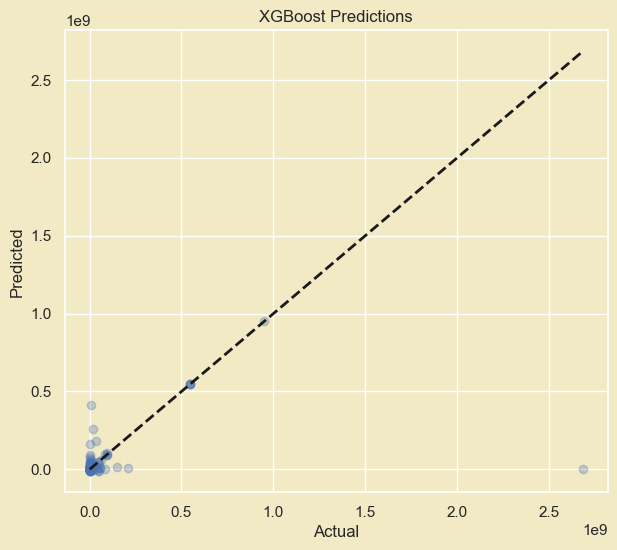

In [ ]:
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")

# Plot the results
plt.figure(figsize=(7, 6))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Predictions')
plt.show()

In [ ]:
def clean_column_names(df):
    # Replace spaces and slashes with underscores
    df.columns = [col.replace(' ', '_').replace('/', '_') for col in df.columns]
    # Convert to lowercase
    df.columns = [col.lower() for col in df.columns]
    return df

# Assuming df2023 is your DataFrame
df2023 = clean_column_names(df)

In [ ]:
# Define prediction function to match provided columns
def predict_popularity(title, department_agency, cgac, sub_tier, fpds_code, office, aac_code, 
                       posted_date, contract_type, base_type, archive_type, darchive_date, 
                       set_aside_code, set_aside, response_deadline, naics_code, 
                       classification_code, pop_street_address, pop_city, pop_state,
                       pop_zip, pop_country, award_number, award_date, award_amount,
                       awardee, primary_contact_title, primary_contact_fullname,
                       primary_contact_email, primary_contact_phone, primary_contact_fax, 
                       secondary_contact_title, secondary_contact_fullname, secondary_contact_email, 
                       secondary_contact_phone, secondary_contact_fax, organization_type, state, 
                       city, zip_code, country_code, additional_info_link, link, description):

    # Hash specific text fields to match the model's expected input format
    title_hashed = hash(str(title)) % 10**8
    department_agency_hashed = hash(str(department_agency)) % 10**8
    sub_tier_hashed = hash(str(sub_tier)) % 10**8
    awardee_hashed = hash(str(awardee)) % 10**8

    # Create a DataFrame for the input, matching the column names in X
    input_data = pd.DataFrame([[
        title_hashed, department_agency_hashed, cgac, sub_tier_hashed, fpds_code,
        office, aac_code, posted_date, contract_type, base_type, archive_type,
        set_aside_code, set_aside, response_deadline, naics_code, classification_code,
        pop_street_address, pop_city, pop_state, pop_zip, pop_country,
        award_number, award_date, award_amount, awardee_hashed, primary_contact_title,
        primary_contact_fullname, primary_contact_email, primary_contact_phone,
        primary_contact_fax, secondary_contact_title, secondary_contact_fullname,
        secondary_contact_email, secondary_contact_phone, secondary_contact_fax,
        organization_type, state, city, zip_code, country_code, additional_info_link,
        link, description
    ]], columns=X.columns)

    # Define numeric columns, if any, to normalize
    # (Assume 'award_amount' as a numerical example, modify as needed based on your data)
    numerical_cols = ['award_amount']
    input_data[numerical_cols] = (input_data[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std()

    # Return the DataFrame ready for prediction
    return input_data


In [ ]:
X_train.dtypes.to_frame('Data Type')

,Data Type
title,int64
sol_,int64
department_ind_agency,int64
cgac,int64
sub_tier,int64
fpds_code,int64
office,int64
aac_code,int64
posteddate,int64
type,int64


In [ ]:
# Missing values in each row
missing_values_per_row = X_train.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (X_train.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

1638 row(s) have 0 missing values
Total number of rows with missing values: 0


In [ ]:
dist_numerical_cols = X_train.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = X_train.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (X_train.isnull().mean() * 100).round(2)

The output shows that all numeric columns have a missing value percentage of 0, indicating that **there are no missing values** in these columns.

To gain further insights into the data, we used the `describe()` method to generate a comprehensive statistical summary of the numerical columns.

**👉 Distribution of numerical columns**

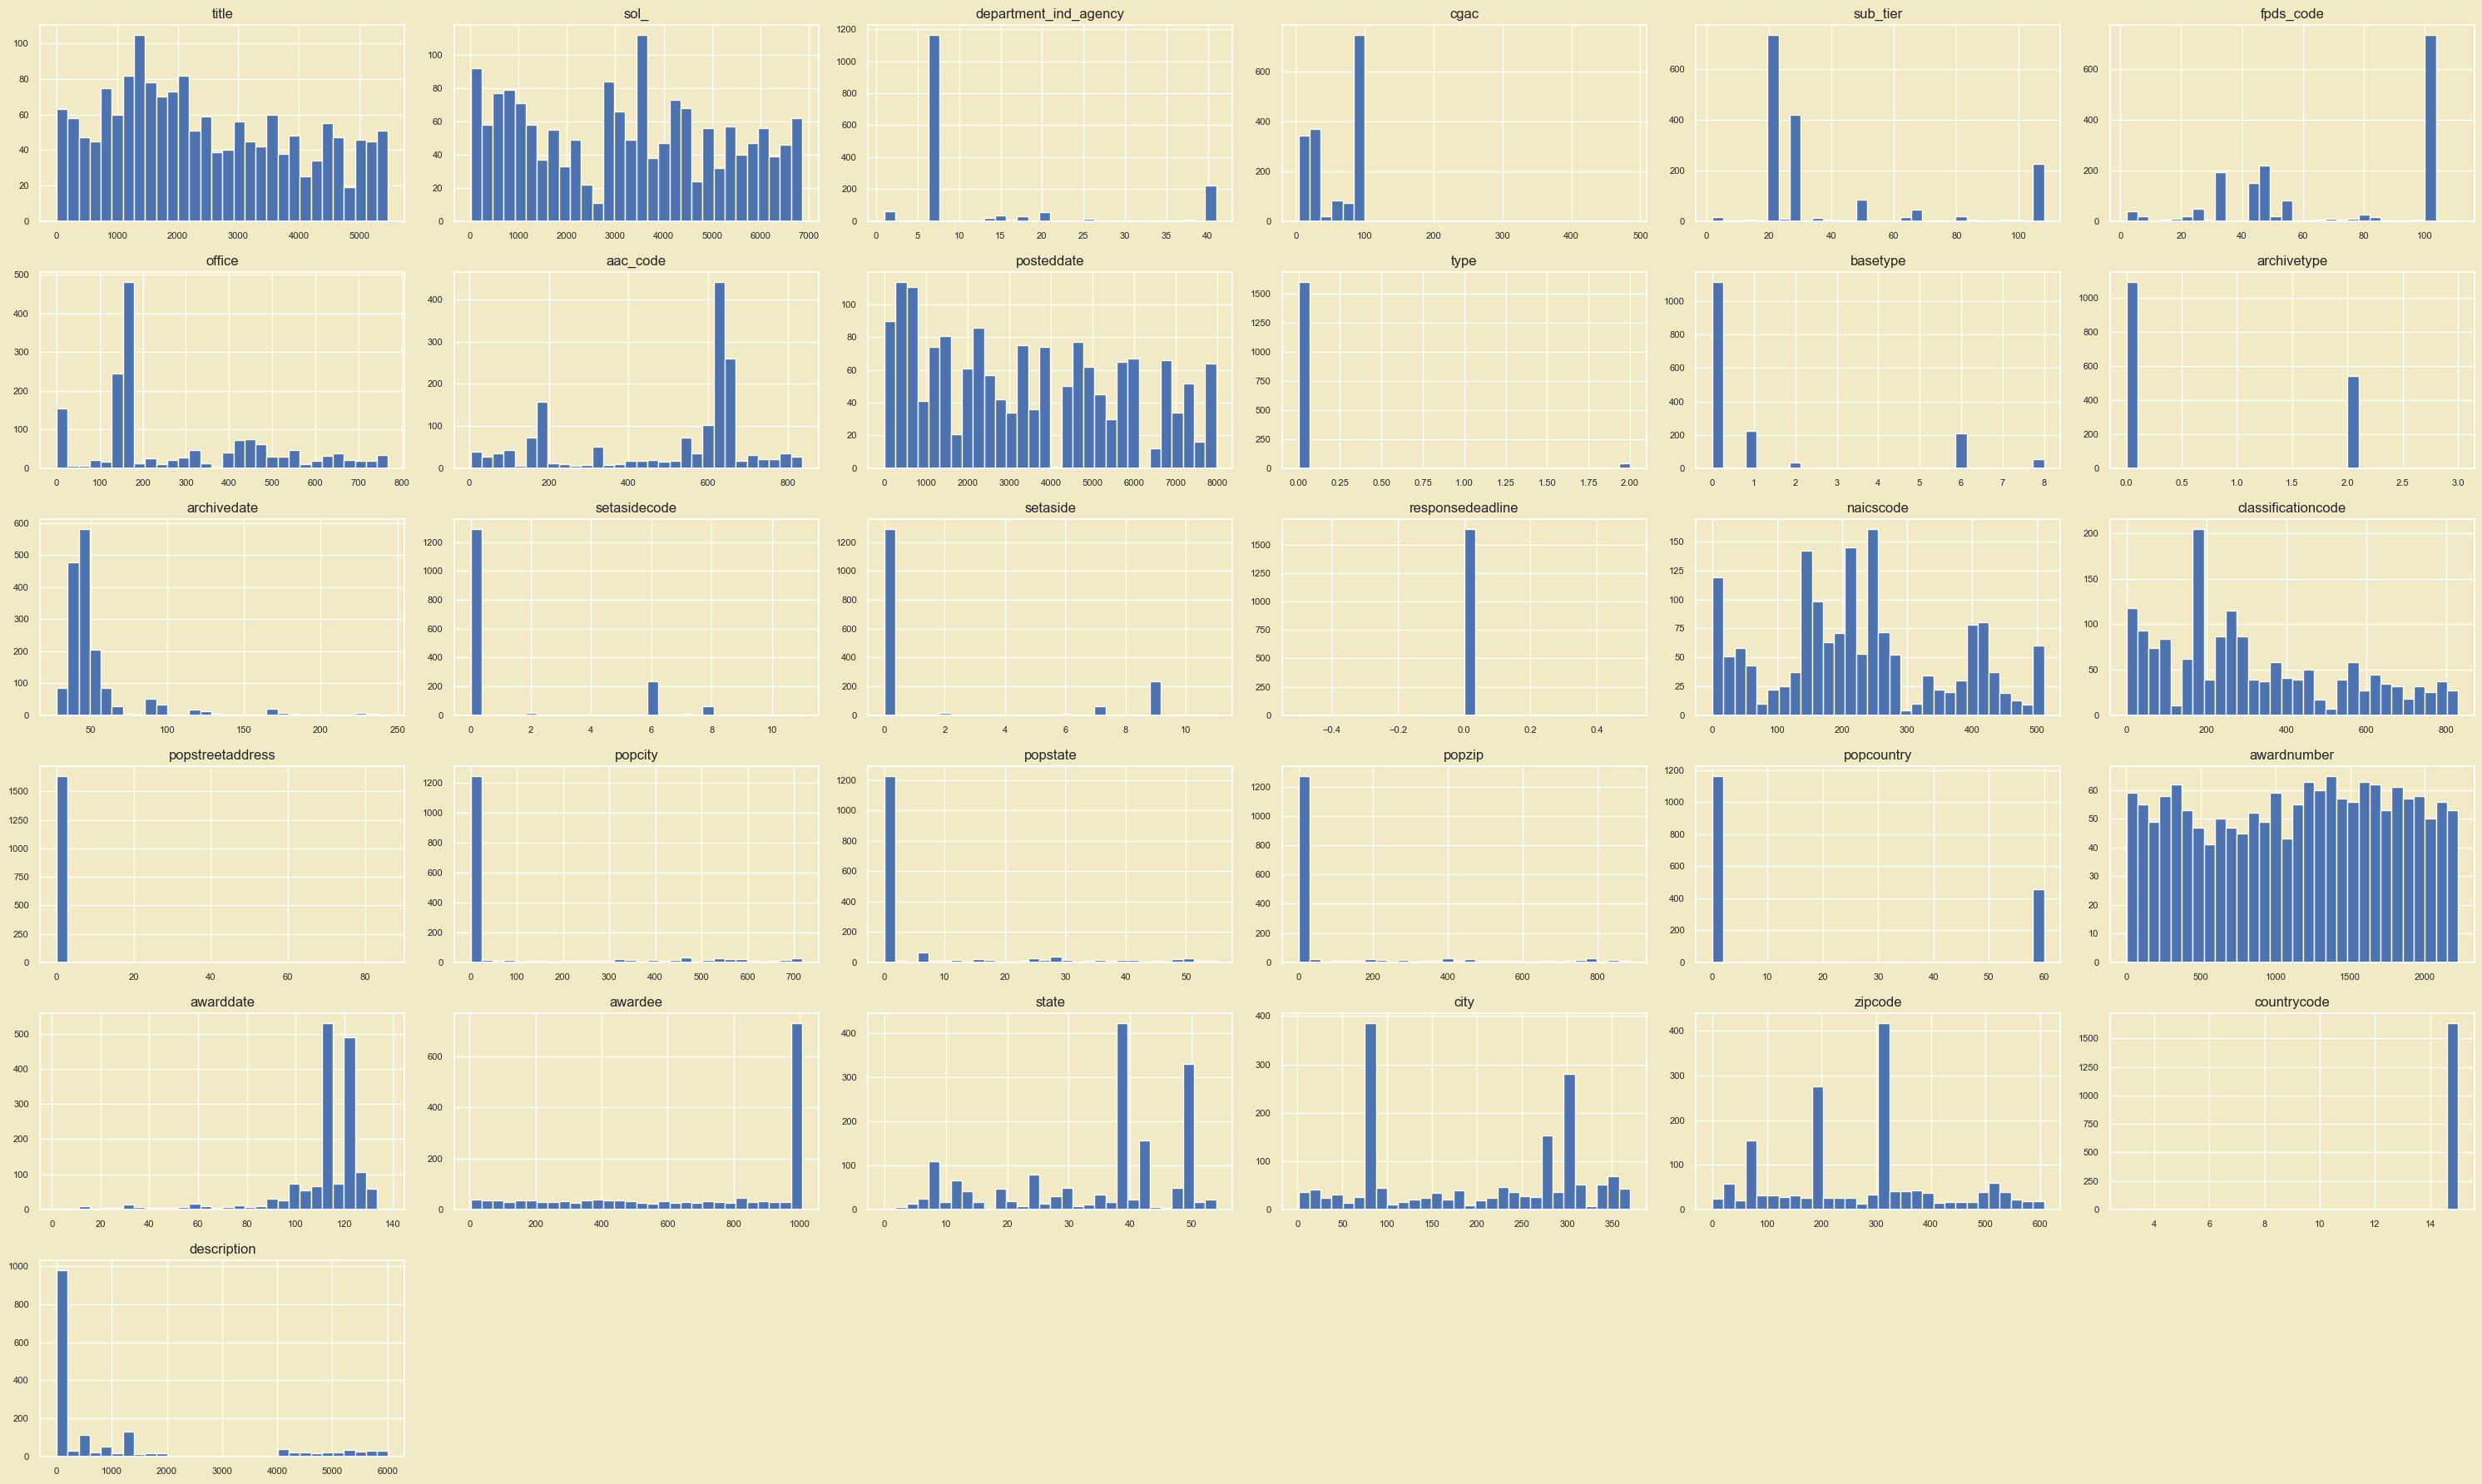

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
X_train.hist(figsize=(30,18), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

<Figure size 3200x1500 with 0 Axes>

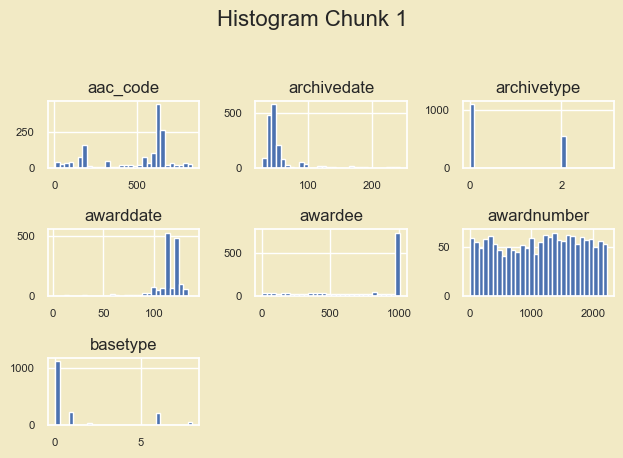

<Figure size 3200x1500 with 0 Axes>

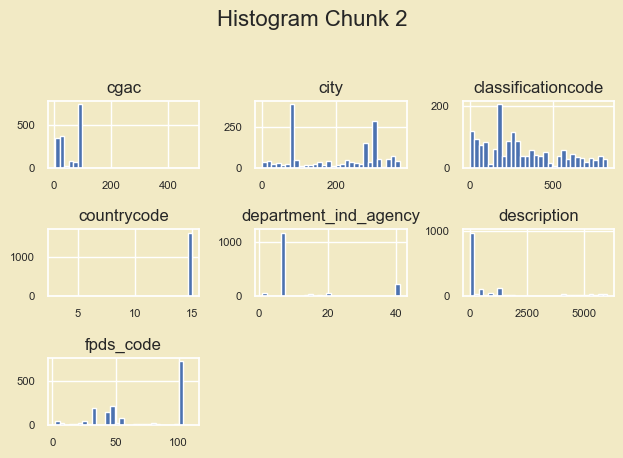

<Figure size 3200x1500 with 0 Axes>

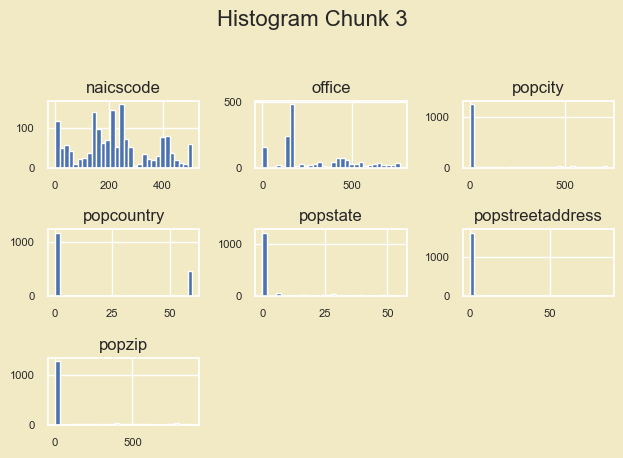

<Figure size 3200x1500 with 0 Axes>

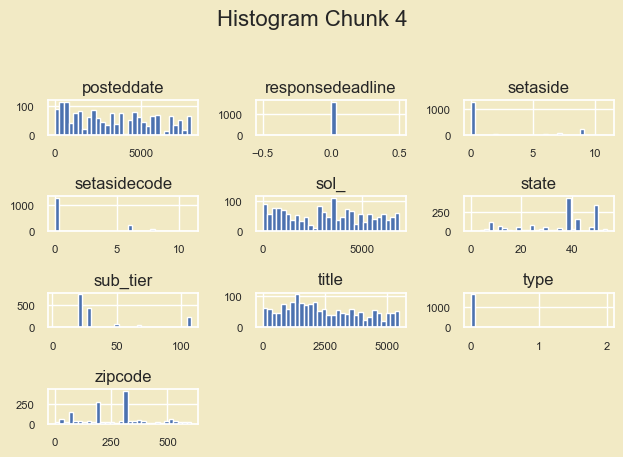

In [ ]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# Sort the columns by name
sorted_columns = sorted(X_train.columns)

# Split columns into four roughly equal parts
num_chunks = 4
chunk_size = len(sorted_columns) // num_chunks
chunks = [sorted_columns[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

# If there are remaining columns, add them to the last chunk
if len(sorted_columns) % num_chunks != 0:
    chunks[-1].extend(sorted_columns[num_chunks * chunk_size:])

# Plot histograms for each chunk
for idx, chunk in enumerate(chunks, 1):
    plt.figure(figsize=(32, 15))
    X_train[chunk].hist(bins=30, xlabelsize=8, ylabelsize=8)
    plt.suptitle(f'Histogram Chunk {idx}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
unique_values = X_train.nunique()
missing_values = X_train.isnull().sum()

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'Missing Values': missing_values
})

In [ ]:
summary_sorted = summary.sort_values(by='Unique Values', ascending=True)

print(summary_sorted)

                       Unique Values  Missing Values
responsedeadline                   1               0
countrycode                        2               0
type                               2               0
popstreetaddress                   3               0
archivetype                        3               0
basetype                           6               0
popcountry                        10               0
setasidecode                      10               0
setaside                          10               0
department_ind_agency             21               0
cgac                              24               0
state                             49               0
popstate                          50               0
sub_tier                          56               0
fpds_code                         56               0
archivedate                       88               0
awarddate                        111               0
city                             196          

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1638 entries, 7254 to 5315
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   title                  1638 non-null   int64
 1   sol_                   1638 non-null   int64
 2   department_ind_agency  1638 non-null   int64
 3   cgac                   1638 non-null   int64
 4   sub_tier               1638 non-null   int64
 5   fpds_code              1638 non-null   int64
 6   office                 1638 non-null   int64
 7   aac_code               1638 non-null   int64
 8   posteddate             1638 non-null   int64
 9   type                   1638 non-null   int64
 10  basetype               1638 non-null   int64
 11  archivetype            1638 non-null   int64
 12  archivedate            1638 non-null   int64
 13  setasidecode           1638 non-null   int64
 14  setaside               1638 non-null   int64
 15  responsedeadline       1638 non-null   i

In [ ]:
# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"Ridge Regression MSE: {ridge_mse}, R2: {ridge_r2}")

Random Forest MSE: 2.97289532981604e+16, R2: -0.3109340983152422
Ridge Regression MSE: 2.9501081317882692e+16, R2: -0.30088580815175514


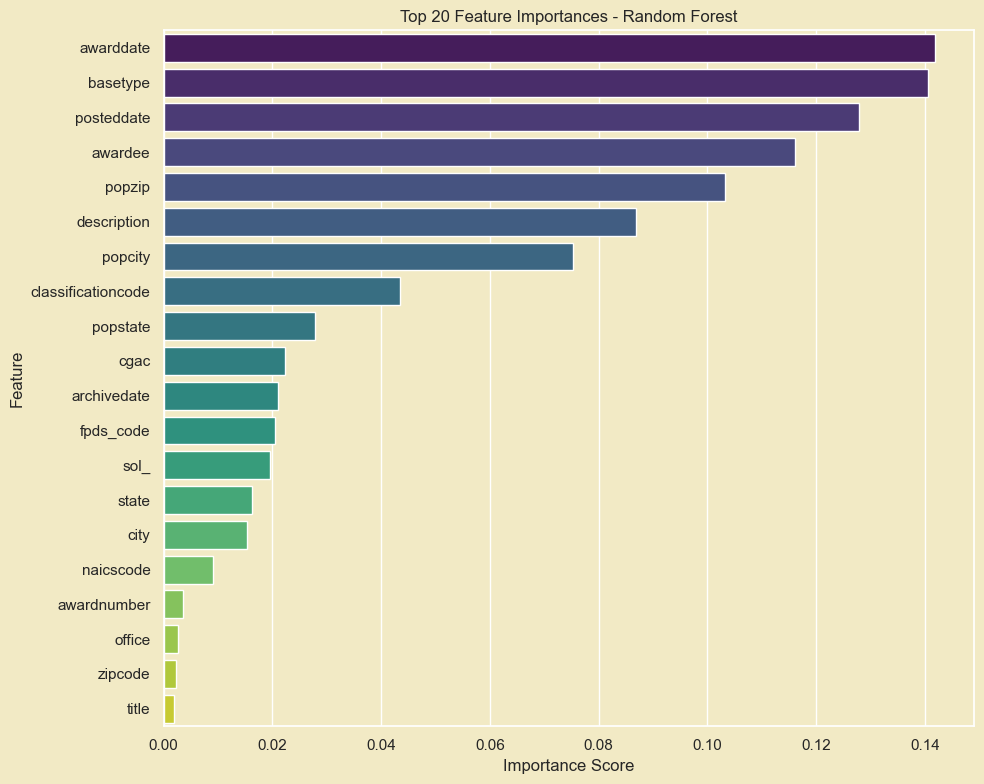

In [ ]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# 1. Feature Importance for Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)  # Top 20 features

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

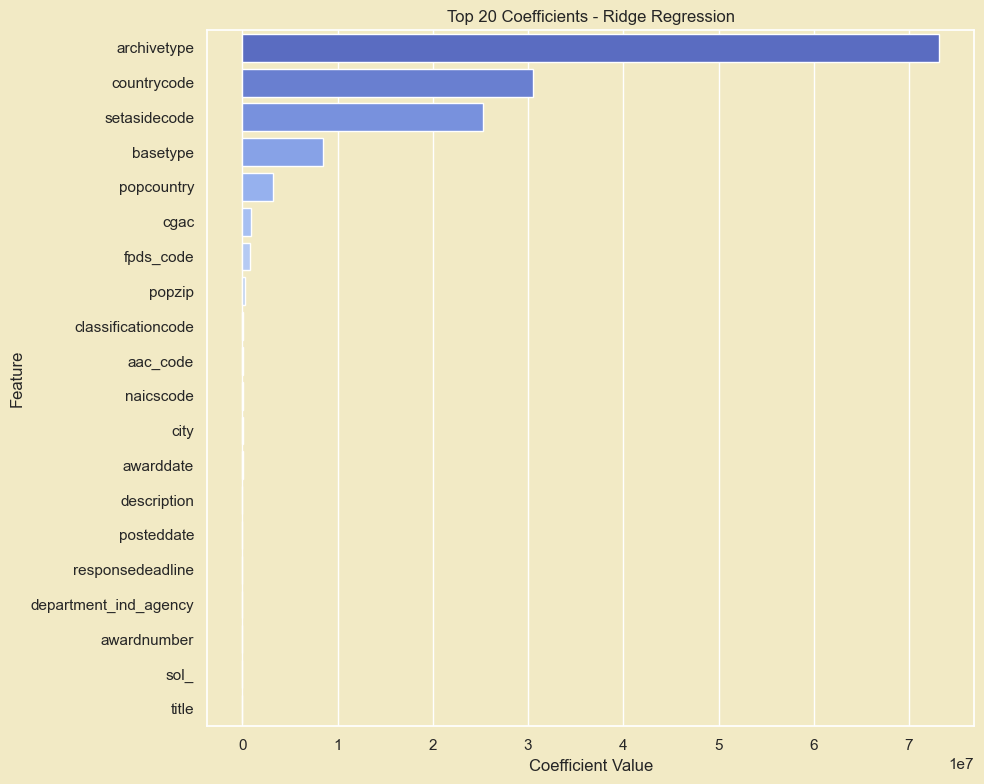

In [ ]:
# 2. Coefficient Analysis for Ridge Regression
coefficients = ridge_model.coef_
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False).head(20)  # Top 20 positive coefficients

plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=coef_df, palette='coolwarm')
plt.title('Top 20 Coefficients - Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

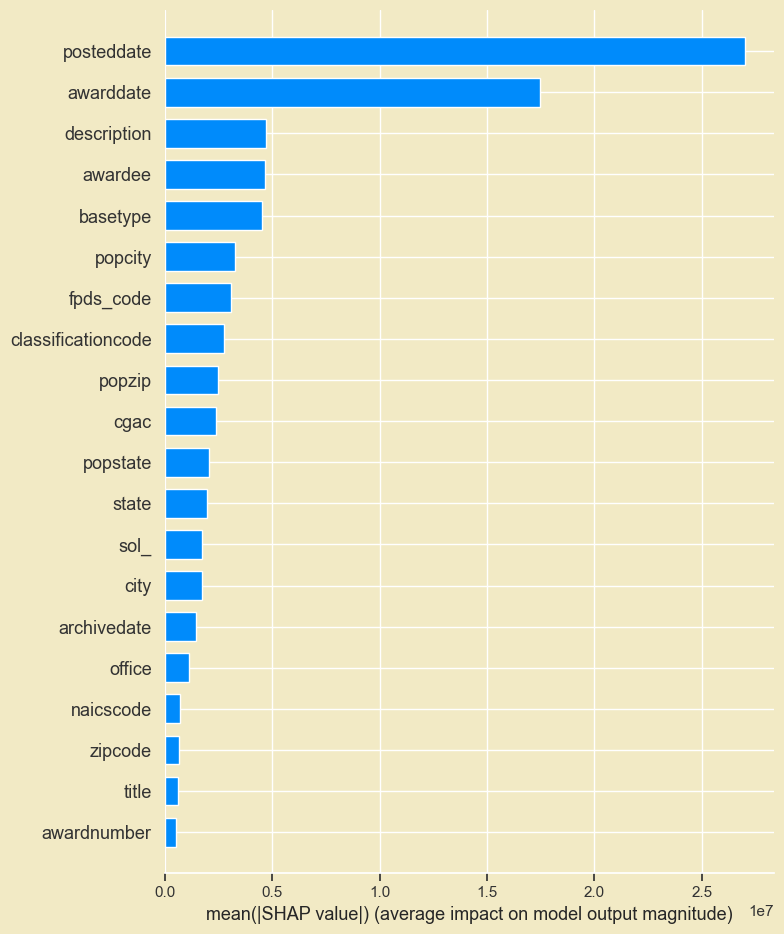

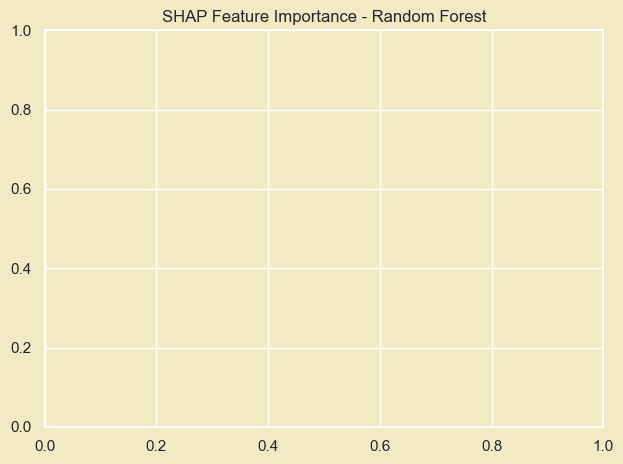

In [ ]:
# 3. SHAP Values for Model Explainability
# Random Forest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")
plt.title('SHAP Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

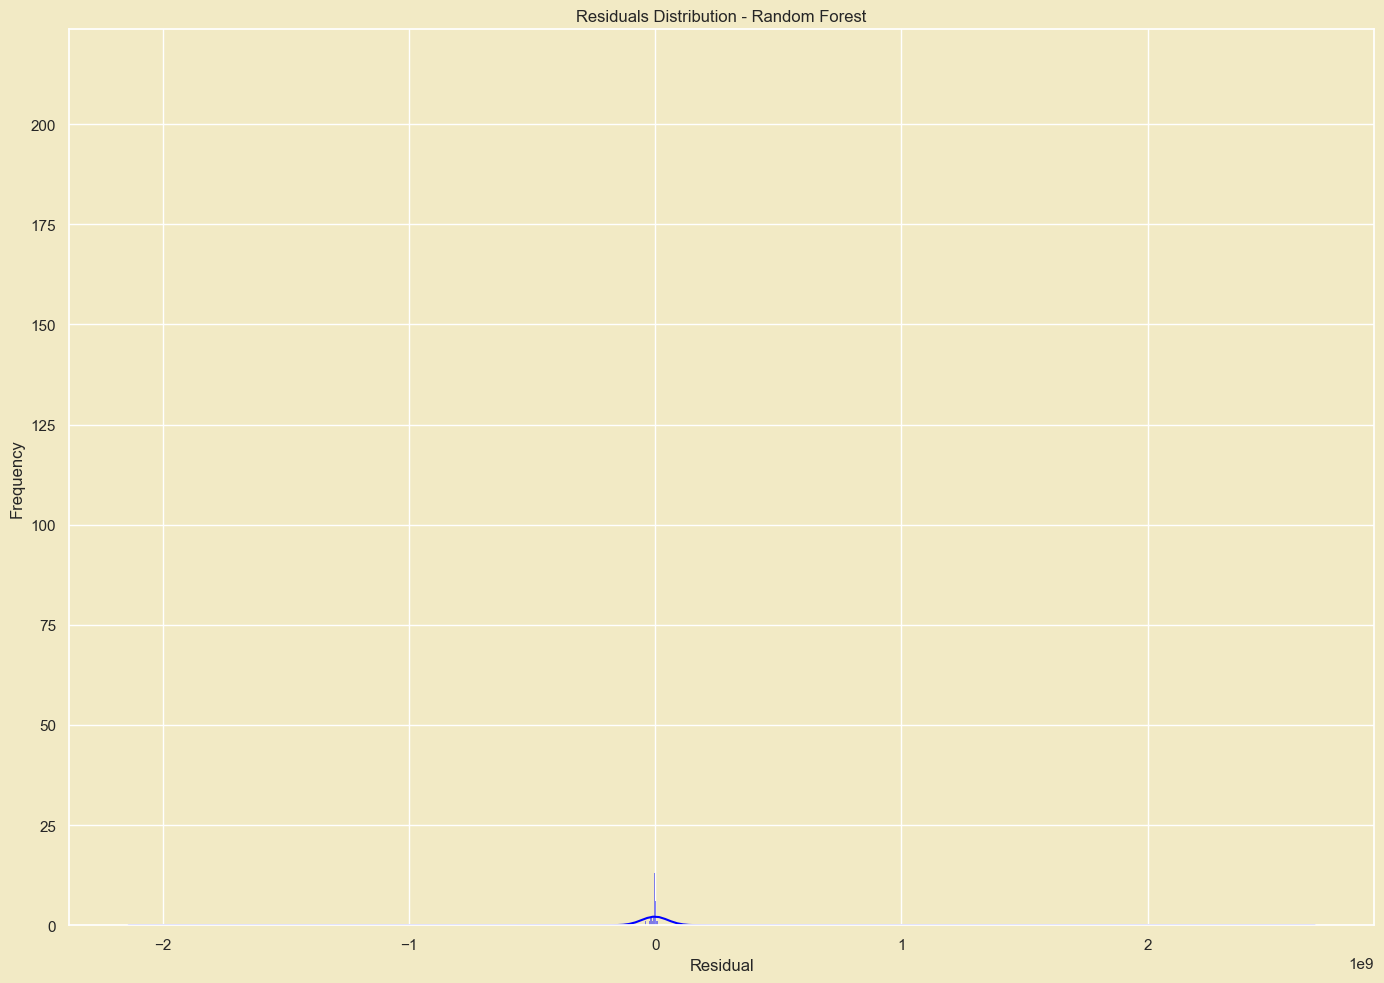

In [ ]:
# 4. Residual Plots
# Random Forest Residuals
rf_residuals = y_test - rf_predictions
plt.figure(figsize=(14, 10))
sns.histplot(rf_residuals, kde=True, color='blue')
plt.title('Residuals Distribution - Random Forest')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

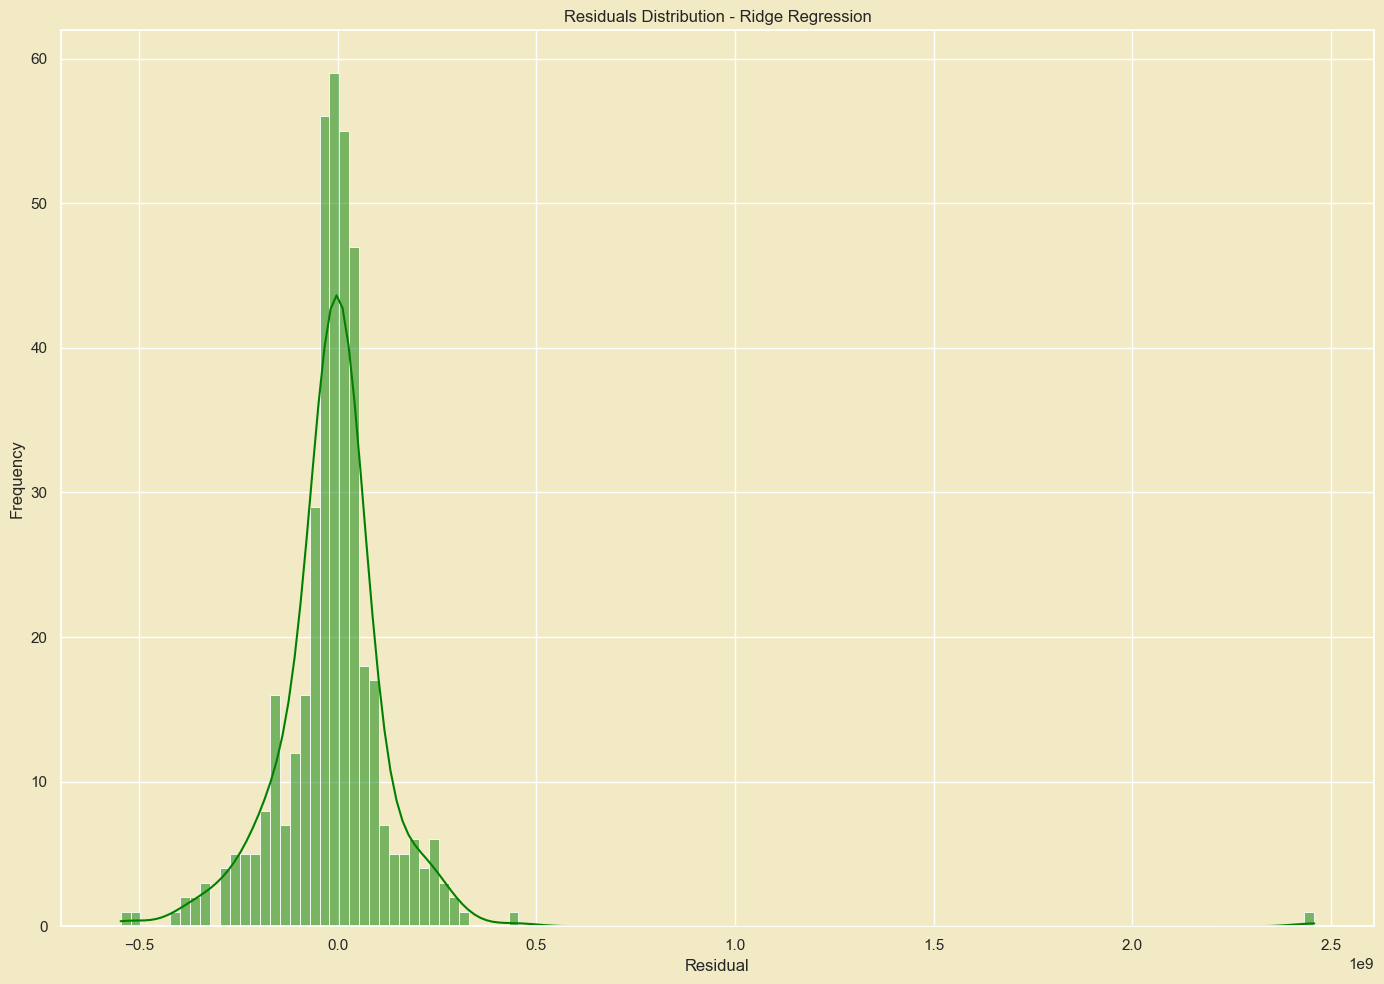

In [ ]:
# Ridge Regression Residuals
ridge_residuals = y_test - ridge_predictions
plt.figure(figsize=(14, 10))
sns.histplot(ridge_residuals, kde=True, color='green')
plt.title('Residuals Distribution - Ridge Regression')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Actual vs. Predicted - Random Forest')

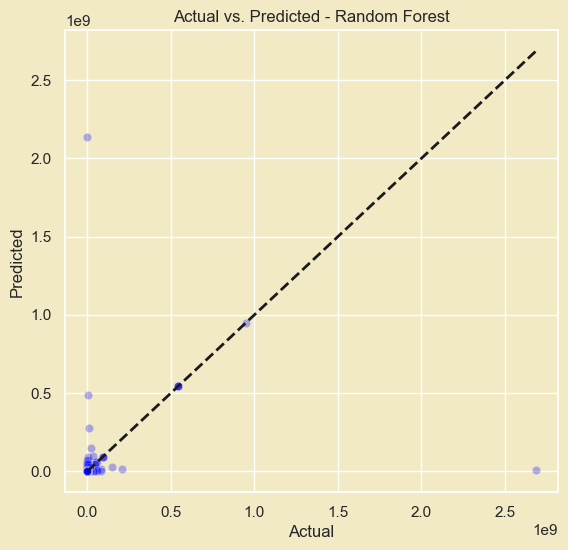

In [ ]:
# 5. Actual vs. Predicted Scatter Plots
plt.figure(figsize=(14, 6))

# Random Forest
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=rf_predictions, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Random Forest')

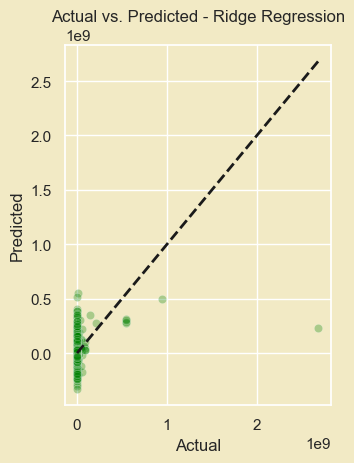

In [ ]:
# Ridge Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=ridge_predictions, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Ridge Regression')

plt.tight_layout()
plt.show()

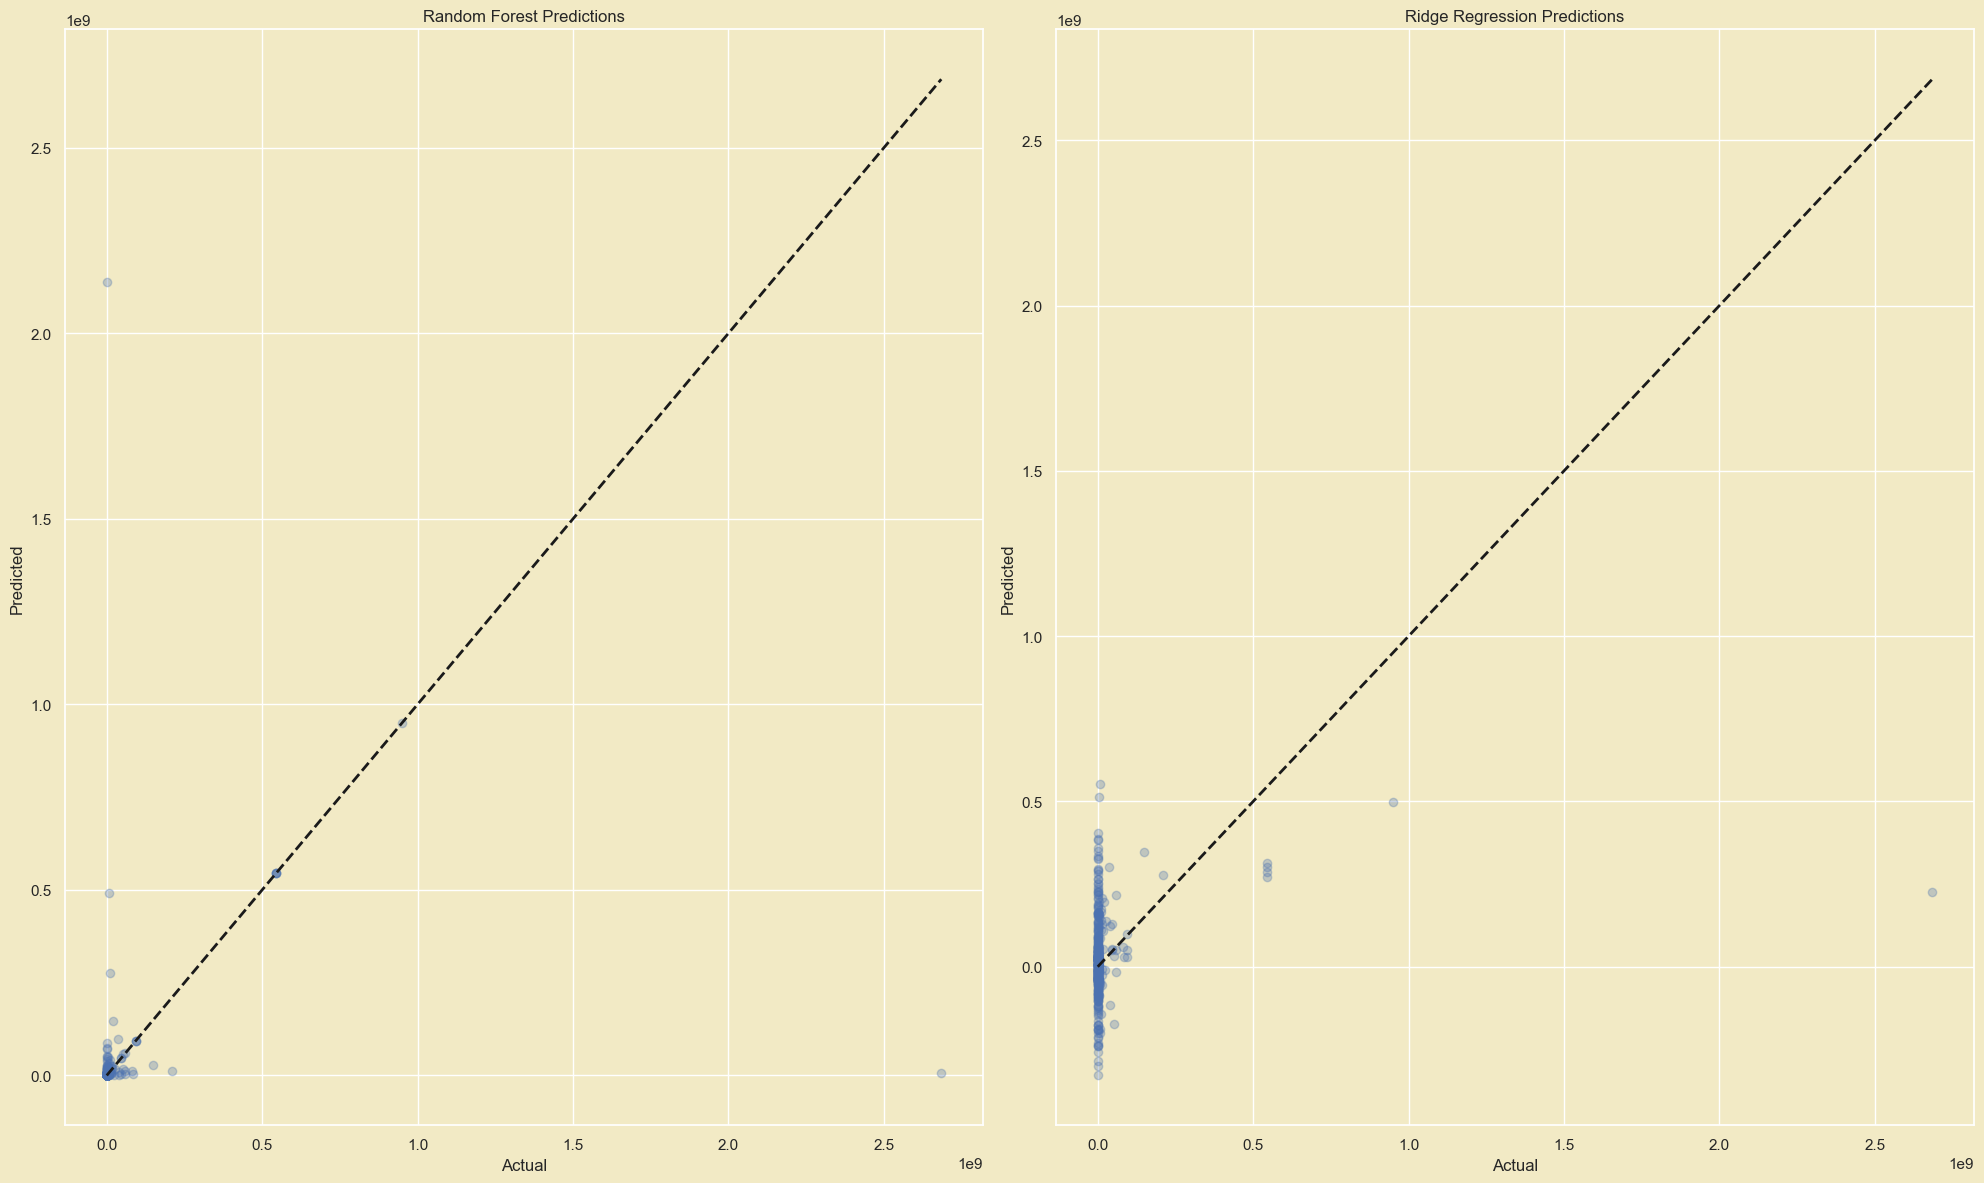

In [ ]:
# Plot the results
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression Predictions')

plt.tight_layout()
plt.show()